# Possible solution to exercise series 5

In [1]:
#imports useful for this exercise
import numpy as np
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mp

import IPython

np.set_printoptions(linewidth=100)

# a few functions to construct Laplacian and incidence matrix

In [2]:
#returns the Laplacian of graph specified by E (list of edges)
def getLaplacian(E,n_vertex):
    L = np.zeros([n_vertex,n_vertex]) #our Laplacian matrix
    Delta = np.zeros([n_vertex,n_vertex]) #this is the degree matrix
    A = np.zeros([n_vertex,n_vertex]) #this is the adjacency matrix
    for e in E: #for each edge in E
        #add degrees
        Delta[e[1],e[1]] +=1
        #add the input in the adjacency matrix
        A[e[1],e[0]] = 1
        #symmetric connection as we have undirected graphs
        Delta[e[0],e[0]] +=1
        A[e[0],e[1]] = 1
    L = Delta - A
    return L

# get incidence matrix for directed graph E (list of edges)
def getIncidenceMatrix(E,n_vertex):
    n_e = len(E)
    D = np.zeros([n_vertex,n_e])
    for e in range(n_e):
        #add the directed connection
        D[E[e][0],e] = -1
        D[E[e][1],e] = 1
    return D

# function to make animation of the agents after simulation

In [3]:
# function to create movie of the agents moving with obstacles
def make_animation_obstacles(plotx,E,obstacles,xl=(-2,2),yl=(-2,2),inter=25, display=False):
    fig = mp.figure.Figure()
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=xl, ylim=yl)
    ax.grid()

    list_of_lines = []
    for i in E: #add as many lines as there are edges
        line, = ax.plot([], [], 'o-', lw=2)
        list_of_lines.append(line)
    for obs in obstacles: #as many rounds as there are obstacles
        line, = ax.plot([obs[0]],[obs[1]],'ko-', lw=15)
        list_of_lines.append(line)

    def animate(i):
        for e in range(len(E)):
            vx1 = plotx[2*E[e][0],i]
            vy1 = plotx[2*E[e][0]+1,i]
            vx2 = plotx[2*E[e][1],i]
            vy2 = plotx[2*E[e][1]+1,i]
            list_of_lines[e].set_data([vx1,vx2],[vy1,vy2])
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=inter, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    if(display==True):
        IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))
    return ani

# Function that simulates the system
We are using the control law for each agent $$\begin{bmatrix}\ddot{x}_i\\ \ddot{y}_i \end{bmatrix} = F_{formation,i} + F_{target,i} + F_{obstacle,i}$$

## Formation control law
Here we choose the linear formation control seen in the class
$$F_{formation,i} = \begin{bmatrix} K_F (D z_{x,desired} - L x)_i + D_F (D \dot{z}_{x,desired} - L \dot{x})_i\\ K_F (D dz_{y,desired} - L y)_i + D_F (D \dot{z}_{y,desired} - L \dot{y})_i \end{bmatrix}$$ where $K_F$ and $D_F$ and positive gains, $L$ is the graph Laplacian, $D$ is the incidence matrix and $z_{desired}$ is the desired set of desired direction vectors associated to each edges. Here we wrote the control law in matrix form where $x = [x_1, x_2, \cdots, x_n]^T$ and $y = [x_1, x_2, \cdots, x_n]^T$ and it is understood that we take the ith line of the results to apply to agent i.

## Motion to target law
We choose the following proportional derivative control law to move the formation towards the target
$$F_{target,i} = \begin{bmatrix} K_T * min(x_{goal} - x_i,1.) - D_T \dot{x}_i \\ K_T * min(y_{goal} - y_i,1.) - D_T \dot{y}_i \end{bmatrix}$$
where $K_T$ and $D_T$ are positive gains, $[x_{goal}, y_{goal}]$ is the position of the goal and we limit the error to the distance to the goal in magnitude to be lower than 1.0 (here we assume min is the min in absolute value terms). This ensures that the maximum acceleration does not grow as the goal is further.

## Obstacle avoidance control law
We choose an exponential function to repeal an agent from an obstacle. Note that any potential function can be used, in particular the potential functions seen in Lecture 9 and 10 might be more efficient.
$$F_{obstacle,i} = \sum_{j \in \mathrm{obstacles}} K_O \frac{1}{\sqrt{2\pi \sigma^2}}\mathrm{e}^{-\frac{(x_i-x_{obstacle,j})^2 + (y_i-y_{obstacle,j})^2}{2\sigma^2}} \begin{bmatrix}\frac{x_i - x_{obstacle,j}}{\sqrt{(x_i-x_{obstacle,j})^2 + (y_i-y_{obstacle,j})^2}} \\ \frac{y_i - y_{obstacle,j}}{\sqrt{(x_i-x_{obstacle,j})^2 + (y_i-y_{obstacle,j})^2}} \end{bmatrix}$$
where $K_O$ is a positive gain and $\sigma$ is a positive number controlling the width of the exponential (e.g. how far away does an obstacle influence an agent).

In [4]:
# simulate a 2nd order formation control law with goal directed motion and obstacle avoidance
def simulate_form_target_obst(x_0, v_0, T, E, z_des, v_des, goal_des, obstacles, dt=0.001,KF=1,KT=1,KO=1):
    nt = int(T/dt) #number of steps to simulate
    n = len(x_0) #size of state vector
    ne = n/2 #number of agents
    x = np.zeros([n,nt]) #pre allocation of vector of positions
    v = np.zeros([n,nt]) #pre allocation of vector of velocities
    t = np.zeros(nt) #allocation of time
    x[:,0] = x_0 #initial state
    v[:,0] = v_0 #initial velocity
    L = getLaplacian(E,n/2) #graph Laplacian
    D = getIncidenceMatrix(E,n/2) #incidence matrix
    DF = 2*np.sqrt(KF) #DF is set to have critical damping for formation control
    DT = 2*np.sqrt(KT) #DT is set to have critical damping for target control
    
    #for each time step
    for i in range(0,nt-1):
        #integrate the state from previous velocity
        x[:,i+1] = x[:,i] + dt * v[:,i]
        
        #compute Formation control law (using matrix form for efficiency and ease to write)
        Fx = (KF*(D.dot(z_des[0::2])-L.dot(x[0::2,i])) + DF*(D.dot(v_des[0::2])-L.dot(v[0::2,i])))
        Fy = (KF*(D.dot(z_des[1::2])-L.dot(x[1::2,i])) + DF*(D.dot(v_des[1::2])-L.dot(v[1::2,i])))
        # add the target control
        Fx += KT * np.minimum((goal_des[0] - x[0::2,i]),1.) - DT*v[0::2,i]
        Fy += KT * np.minimum((goal_des[1] - x[1::2,i]),1.) - DT*v[1::2,i]
        
        #for each obstacle - add the repealing force
        for obs in obstacles:
            #compute distance to obstacle
            d = (x[0::2,i]-obs[0])**2 + (x[1::2,i]-obs[1])**2
            sig = 0.5 #width of the gaussians
            #adding obstacle avoidance force
            Fx += KO * (1/np.sqrt(2*np.pi*sig**2))*np.exp(-d/(2*sig**2))*(x[0::2,i]-obs[0])*(1/np.sqrt(d))
            Fy += KO * (1/np.sqrt(2*np.pi*sig**2))*np.exp(-d/(2*sig**2))*(x[1::2,i]-obs[1])*(1/np.sqrt(d))
        #integrate velocity from previous vel and desired control force
        v[0::2,i+1] = v[0::2,i]+dt*Fx
        v[1::2,i+1] = v[1::2,i]+dt*Fy
        #time increase
        t[i+1] = t[i] + dt
    return t,x,v

<IPython.core.display.Javascript object>


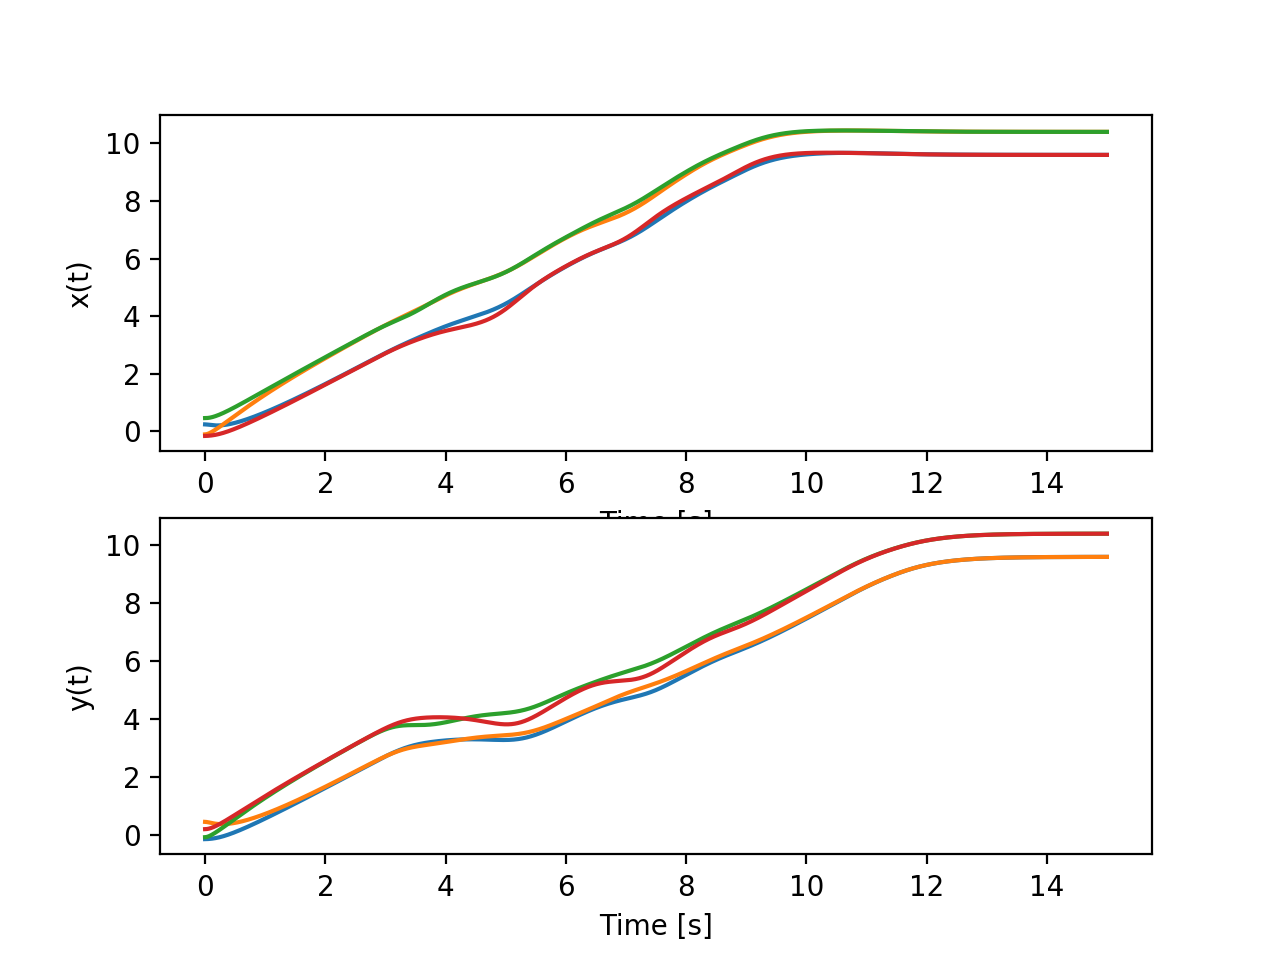

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACMCG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQ4IHIyNzk1IGFhYTlhYTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTIgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAS0WWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAAA/yP425VR62BLgAAAE7ADhh/uP
AHr8ACfgwFBJBg4cw/wYJMGQVxgZ9QMo4j4o+Dv2BrPR6a8z7E1WjNq0Fp6Vmd/LnhwtnTaXtdqV
jOWOXGrAXcsFzMiRsB+UVVFIV+5u2wRAqSiM1NtlBtUlq2Baf3IY5zkOy4hOPcHQxorkkmByl9R6
gu2lXbvxCk9BQ6uq7a8P4WgVpdxNMIaJs/nV+8AhKcGOdjq/vEb+KtVgReuBUs/CiVSQhuNlaySD
K3Oxk69AVZbqe3n5aRtR0/U8hk5el/x73MiOB6XccX+n0wGWEMWR/XwvAV6qO8R6UzxupeeXnA3a
kDl0z4d+OwmTZ7jog/cmy2794d1js2fJAUOQ+giurb8ydxU+H+TMauiRioz6E6x7YwFoUIVq0J8O
YUi38k8rgjZguXXbwcCMIT6LRphfSv3WtBYjXNs/GDFKzcmOM851Y15o2Jn3C5HYf/KFkmLR/5Pa
V9x967SckwQuJigBcSdCVgpoF92f3uRxOh1TqPj1avYGooXwCAZkP7gVUoYeODH06/l7nYB7pDoh
KBkyqCDYTHaey0Kjs1QAzBm6/H9loH7Z1RSnovYyYX9t+WCS8nN5jE7n0GhvfvW9nbHpWgZuCJN+
dyT9DS/na5Sj1Xpt6xxwx8Hposzte7BnVsTUgZRsK26bXGd0MCX+HA2cv/tNRDCA6XTNrS0LQspF
hjp7EBEOP3fdA+iuSTb6lQKRrC+R+oz2DgzmVNVioMHeLyhs46EzjyJX7gWmEiwMFfiClc6oRFMV
p95C93VYN+GJvznqjRmnu7jMG0zjrtWdc8svc9odwc0FtkhZfLN/DbrADWHwXVr/6XXY4jzdXM8i
mzufQCE0f7V5SAlYwy5+YAXEPAJYVRQGhcgFo7K1UjWsU1Y6HSTbAe2yI5GlQ9JFqW4ZsP8gf5j8
xq6h3f05p20qr/W8TL/3n/LyHM65qHWsbM2peLxm32QqQOkj/d3HxMiyiyyskq0YbRgzdfvW12c4
PD0G3I/COq6/F1yA5AAlBn+lGwYIVWv8TtkWs8DykZjNr5ebR1pSkqN6NnWmTUzVAUEnpkhTKJPa
5uAe2NkvjfCP0iUTwX6A4O1u5x54roCg+4NOPAMjcsdGoFxTxDHu7xZpILI4pyDEhFu+DmI50XS4
fkJSdUWx9SsSWvwaY8bEY6Bkplvi9oIHDCHYbVCVtepIgFM42wpPbGQOupwFs6hGklJEJNdH16Mw
ts5BvE3CwYOJO4WyruJUh+ZskbMSZi069YZ8c48JejjOSOt0ZlvjtvkrRqNExFmk7FDkolXNrCZN
Bm6fTOWrWnJ1Ydnf/+Ghwn2QNFLQNiMh5OqomzsdopMpp3YCGngH8sxM5QU+gHE1BHRW4Vd+76kK
n5B/DjYzc4GXES/LMMAOY97dBnnvxWw4k6QcNoQcgxEjqvqONCnQ14UfaeeT9gE3beraBSRrmciK
Duf+9vp8RXxtxiFjC5fuWj2ppPx2mSSUPffRDMwJeF8oe/boJh/VDl/elTrGT0y1/QMr/pMDIXRM
RBcAf/7NlLhbLk+2ZQTdq0ILJJm8m4tPqn6nDV7oxQ6+7zY5GwoUF4AFLVqemi6hVx/0F0Cc/1bt
ozrOr11hXmwSC7Pz1a+oLJndEOZH14YWnjdr+wYHmAc/CfH4uhfimMqeORPCx6C8KDJ31Xp6bSiX
1/k8jU8fHChmEWNY7Bb9mJtlYpkFMkPS+YRRC/iV0k/lGRuyhN5ycgM4eEfE1TDgWgtjPTGR+3+6
UsXLtKchhj8/VE0ViVBSQYOZSm/4a60ooIWgh8zcrijA2HSCQ2svCmfdZByKiLIJyVG2mk1ncP8+
3kVApJvtTgtrou03vVgh3HCGBq8yNhXmPbW7+yBqtesFbdfvQUD6sqKrQATTcshv71M22vke7Aov
wGc1qXU8dFmidEtzP6g6MzmLYhk/iwlr8WrYjf21IFz8GQm+7Zd9PXMxODDW0wkhFojyiHWfKmGh
G2JO1yUy/bJhA5oX839SGWCRhHtUSd/rCQCRgAAAAwAT6HiOu5ld0oYOyqFL7dvWsPCxMlbffKKy
mXqqy5Nql1cIus5Ok3yKa5zKET3mEm3zNXw2WZODKd9pyfljTXvJsNpvK6Uw7QXJ6k9eRcnwmd8H
E/xX68q55UwYST0vQHUfAhHBbKbfVkU2BazHrLXI//Uxqim5aafYjPoyducL+7up1PXCl17O2kvs
VTp3Ov0hI4MR8McqLBLqHAvWv6MVilaCUp5DiGnW+kOnicSeOrftKD6r9aOikyZvCpyLfSyFsDeD
MByHKmZGBMxJCvlmdh3/S4sonCujr7EObl/NAhpmHtY/NLLuZkrSty31OXMJnJ/hxqRGZGSM9cKn
hJhbT2unj+K7/uD2aJExmCc2h83S7Gvekek0YD/reN4/+QITWlqYj8kBIQt3bU/nqvQJS4IybhLS
JGZZ2RcRlJGZ4kdNSVHgIlNpSzwWiCA5xP5VffNg9D89ttKj31HH/0B4HtOP/DU8chGzQs3n8bG5
9oVTR2B4VTYAuVktaXPxLK6ZVn9qbnzFH5bAu9TU7+vW0AeoGfnUqtQBGPIrlCqSq9hv8RzIYTm9
+rnpMZB3fuwGaFW8ChCMvcjRQ2PHFUAgAAAMlAOXlb+pP6sV5MIDDlPFteYhGRRwXdCUSX9Egbgx
rVAm6w+V4qprxHW/1yphVk24Y43aZde5c18CCfk5BeUR+x12K7x5NhLLvdekdPbLFNeMyILdlPDh
o46/0WpaXuvikW8mSiXhoGfTsZ7jhBu3e1ShFVRvYOIix5b+Fo63rb1bodjOSTriHZaDW+03KeTP
Pa8aJUrDQy1A/5BorTAou

In [5]:
# an example of simulation with obstacles all over the place

#set initial conditions
x_0 = np.random.uniform(np.ones(8)*0.1)-0.5
v_0 = np.zeros(8)
T = 15
# description of graph with list of edges
E = np.array([[0,1],[1,2],[2,3],[3,0]])
# desired direction vector associated to each edge
z_des = np.array([1,0,0,1,-1,0,0,-1])
# desired velocity vector associated to each edge
v_des = np.array([0,0,0,0,0,0,0,0])
# desired goal
goal_des = np.array([10,10])
# list of obstacles in 2D
obstacles = np.array([[4,0],[4,4.5],[4,8],[6,2],[6.5,6],[6,10],[8,4],[8.3,7.8],[8,12]])
#simulate the system
t,x,v = simulate_form_target_obst(x_0, v_0, T, E, z_des, v_des, goal_des, obstacles, KF=10, KT=5, KO=50)

#some plotting of the results
plt.figure()
plt.subplot(2,1,1)
ax = plt.plot(t,x[0::2,:].transpose())
plt.xlabel('Time [s]')
plt.ylabel('x(t)')
plt.subplot(2,1,2)
plt.plot(t,x[1::2,:].transpose())
plt.xlabel('Time [s]')
plt.ylabel('y(t)')

# show the result in a movie
plotx = x[:,0::100]
make_animation_obstacles(plotx, E, obstacles, inter=100, display=True, xl=(-1, 12), yl=(-1, 12))